# Apply PCM to ISAS dataset

Apply PCM method to ISAS dataset (example for a 3D gridded product). Notebook developped in local

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns

from Plotter import Plotter #new class for plots in pyxpcm

## Get data
***

__Using only one file ...__

In [ ]:
ds_path = '/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20151215_fld_TEMP.nc'

In [ ]:
ds_raw = xr.open_dataset(ds_path)
#ds_raw 

In [ ]:
ds_raw['depth'] = -ds_raw.depth
#ds_raw

<font color=blue>__select data in mediterranean__</font>

In [ ]:
ds = ds_raw.sel(latitude=slice(30,45), longitude=slice(-6, 35))
# ds

In [ ]:
ds['TEMP'].isel(time=0, depth=0).plot();

__Or use more than one time step (more tha one file)__

In [2]:
isas_path = '/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/'

#try with one year
start_date = 20150115
end_date = 20151215
time_interval = 100 # TODO: easier way to get time interval, date type
# ISAS time interval is 1 month
dates_range = np.arange(start_date, end_date + time_interval, time_interval)

#for loop
for dt in dates_range:
    ds_path = isas_path + 'ISAS15_ARGO_' + str(dt) +'_fld_TEMP.nc'
    print(ds_path)
    
    # get ds_raw
    ds_raw = xr.open_dataset(ds_path)
    # select mediterranean
    ds_raw = ds_raw.sel(latitude=slice(30,45), longitude=slice(-6, 35)) # TODO: extent outside loop
    #print(ds_raw)
    
    # concat (very slow)
    if dt == start_date: # first iteration
        ds = ds_raw
    else: #concat
        #ds = xr.concat([ds, ds_raw], "time")
        ds = xr.merge([ds, ds_raw])
    # delate ds_raw
    del ds_raw
    #print(ds)
#ds    

/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150115_fld_TEMP.nc
/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150215_fld_TEMP.nc
/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150315_fld_TEMP.nc
/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150415_fld_TEMP.nc
/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150515_fld_TEMP.nc
/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150615_fld_TEMP.nc
/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150715_fld_TEMP.nc
/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150815_fld_TEMP.nc
/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/ISAS15_ARGO_20150915_fld_TEMP.nc
/

In [15]:
ds['depth'] = -np.abs(ds['depth'].values)
#ds

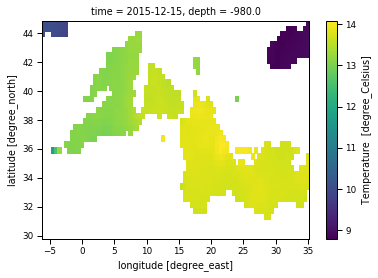

In [4]:
ds['TEMP'].isel(time=11, depth=100).plot();

<font color=red>__TODO__</font> : Use more tha TEMP variable

## Applying PCM
***

### Create PCM

Choise of z (very important to make a good choise) 

In [16]:
#z = np.arange(0.,-2000,-10.)
z = ds['depth'][0:20]
pcm_features = {'temperature': z}
#z

Create model

In [6]:
m = pcm(K=8, features=pcm_features)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [7]:
features_in_ds = {'temperature': 'TEMP'}
features_zdim='depth'
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 31.894730

<font color=red>__TODO__</font> : save all trained PCM in a folder

### Classify data

In [8]:
m.predict(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [9]:
m.predict_proba(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [10]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='TEMP', outname='TEMP' + '_Q', keep_attrs=True, inplace=True)
#ds

## Visualisation
***

In [11]:
P = Plotter(ds.squeeze(), m, data_type = 'gridded')

#### 1. Vertical structure of classes

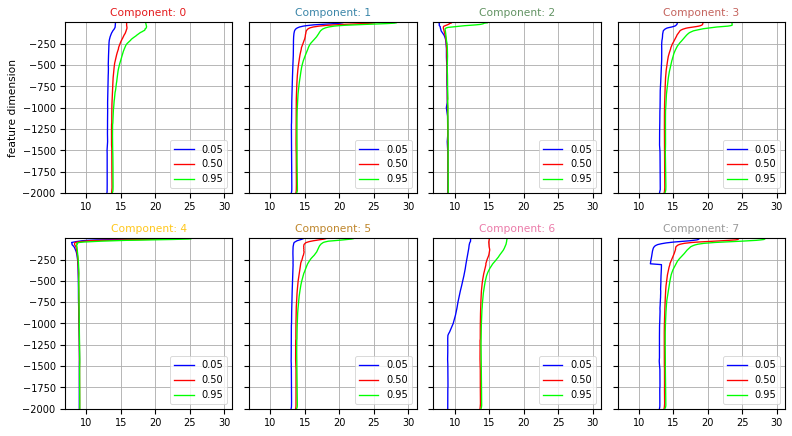

In [12]:
P.vertical_structure(q_variable = 'TEMP_Q')

#### 2. Spatial distribution of classes

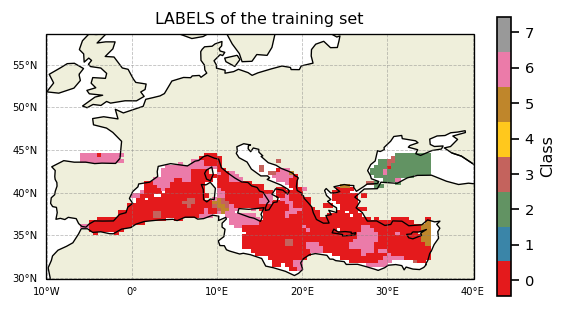

In [13]:
P.spatial_distribution(proj=ccrs.PlateCarree(), 
                       extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       co = {'latitude':'latitude', 'longitude':'longitude'})

#### 3. Posteriors

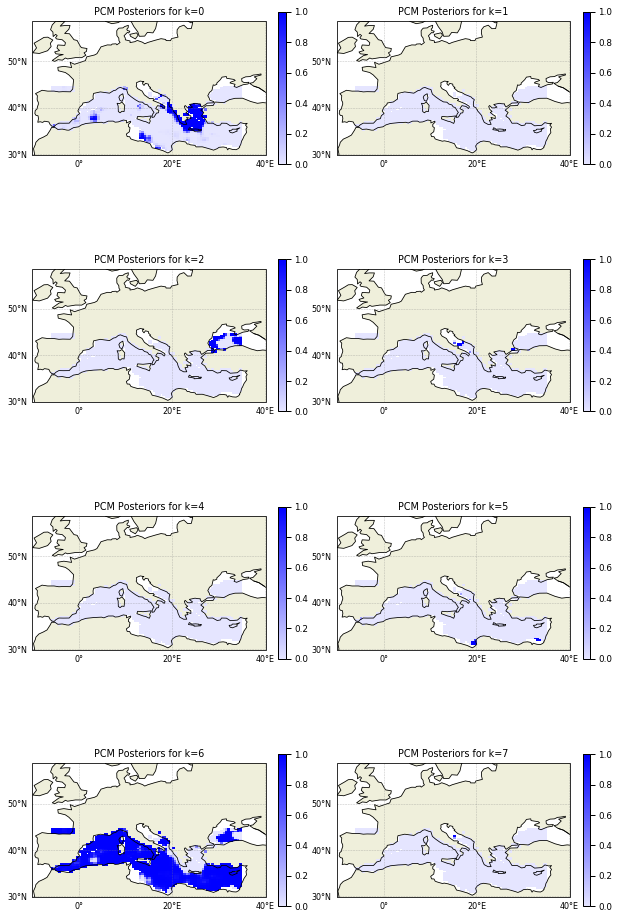

In [14]:
P.plot_posteriors(proj=ccrs.PlateCarree(), extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       co = {'latitude':'latitude', 'longitude':'longitude'})

#### 4. Temporal representation 

<font color=red>__TODO__</font> : Temporal representation in class plotter for 3D gridded data